In [17]:
try:
    # it already installed dependencies
    from torchsummary import summary
    from torchviz import make_dot
except:
    # install graphviz on system
    import platform

    if "Darwin" == platform.system():
        !brew install graphviz
    elif "Linux" == platform.system():
        !sudo apt install graphviz
    else:
        print("go to  https://www.graphviz.org/download/")
    # Next we need to install the following dependencies:
    !pip install torchsummary
    !pip install torch-summary
    !pip install torchviz
    !pip install graphviz
    # import
    from torchsummary import summary
    from torchviz import make_dot

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/main/tutorials/feature-use/global_local_modeling.ipynb)


# Global Local Model
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which a single time series may not reflect the entire time series dynamics. In addition, global models provide better generalization and model size saving. In this notebook, we will build a global model using data from the hourly load of the ERCOT region.

When many time series share only "some behaviour" we will need a **global local model**. In the following notebook we will see an example of time series sharing behaviour/weights on all the components except from the trend and seasonality. Therefore, we will also build a global local model using data from the hourly load of the ERCOT region.

This notebook is an adaptation of `global_modeling.ipynb`.

First, we load the data:

In [18]:
if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed

set_random_seed(10)
set_log_level("ERROR", "INFO")

In [19]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")
df_ercot.head()

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32


We extract the name of the regions which will be later used in the model creation.

In [20]:
regions = list(df_ercot)[1:]

Global models can be enabled when the `df` input of the function has an additional column 'ID', which identifies the different time-series (besides the typical column 'ds', which has the timestamps, and column 'y', which contains the observed values of the time series). We select data from a three-year interval in our example (from 2004 to 2007).

In [21]:
df_global = pd.DataFrame()
for col in regions:
    aux = df_ercot[["ds", col]].copy(deep=True)  # select column associated with region
    aux = aux.iloc[:26301, :].copy(deep=True)  # selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns={col: "y"})  # rename column of data to 'y' which is compatible with Neural Prophet
    aux["ID"] = col
    df_global = pd.concat((df_global, aux))

We will modify one time series trend and one time series seasonality

WARNING - (py.warnings._showwarnmsg) - /var/folders/g5/gjgtytcx0zb3tysnmlfdy0jr0000gn/T/ipykernel_10996/3026129503.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  + 2 * df_global[df_global["ID"] == "COAST"].mean().y



<AxesSubplot:>

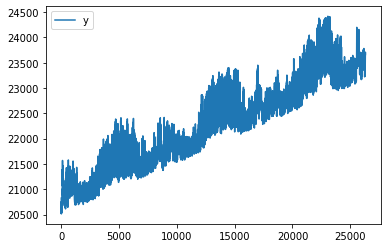

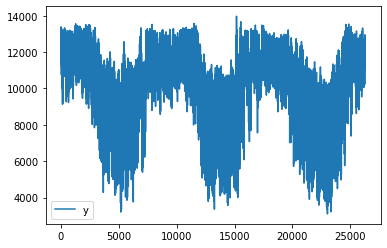

In [22]:
import numpy as np

df_global["y"] = (
    np.where(df_global["ID"] == "COAST", -df_global["y"], df_global["y"])
    + 2 * df_global[df_global["ID"] == "COAST"].mean().y
)
df_global["y"] = np.where(df_global["ID"] == "NORTH", df_global["y"] + 0.1 * df_global.index, df_global["y"])

df_global[df_global["ID"] == "NORTH"].plot()
df_global[df_global["ID"] == "COAST"].plot()

In [23]:
df_global["regressor_id"] = df_global["y"]
df_global["regressor_id2"] = df_global["y"]
df_global["regressor_id3"] = df_global["y"]

In [24]:
df_local = df_global[df_global["ID"] == "COAST"]
df_local = df_local[["ds", "y"]]

In [25]:
m = NeuralProphet()
df_train, df_test = m.split_df(df_global, valid_p=0.33, local_split=True)

## Global Modeling

**Remark:**
- Training a time series only with trend and seasonality components can result in poor performance. The following example is used just to show the new local modelling of multiple time series functionallity.


### STATIC COVARIATES - FUTURE REGRESSORS

In [26]:
m = NeuralProphet(
    #     quantiles=[0.2,0.6],
    trend_global_local="global",
    #     season_global_local="local",
    weekly_seasonality=False,
    yearly_seasonality=False,
    daily_seasonality=False,
    #     yearly_seasonality_glocal_mode="global",
    changepoints_range=0.8,
    #     n_lags=2,
    epochs=1,
    trend_reg=5,
    #     quantiles=[0.1,0.9]
    #     drop_missing=True,
)

In [27]:
m = m.add_future_regressor(name="regressor_id")
m = m.add_future_regressor(name="regressor_id2")
m = m.add_future_regressor(name="regressor_id3", mode="multiplicative")

In [28]:
metrics = m.fit(df_train, freq="H")

Finding best initial lr:   0%|          | 0/278 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [29]:
# interprete_model(m.model, net="ar_net", forward_func="auto_regression")

In [38]:
from captum.attr import Saliency
from neuralprophet.utils_torch import interprete_model

interprete_model(
    m.model,
    net="regressor_nets",
    forward_func="regressor",
    _num_in_features=m.model.regressor_nets["regressor_id"][0].in_features,
    _num_out_features=m.model.regressor_nets["regressor_id"][-1].out_features,
    additional_forward_args="regressor_id2",
)

tensor([[-0.3583]])

When a pd.DataFrame with an 'ID' column is the input for the `split_df` function, train and validation data are provided in a similar format. For global models, the input data is typically split according to a fraction of the time encompassing all time series (default when there is more than one 'ID' and when `local_split=False`). If the user wants to split each time series locally, the `local_split` parameter must be set to True. In this example, we will split our data into train and test (with a 33% test proportion - 2 years train and 1 year test).

After creating an object of the `NeuralProphet`, a model can be created by calling the `fit` function.

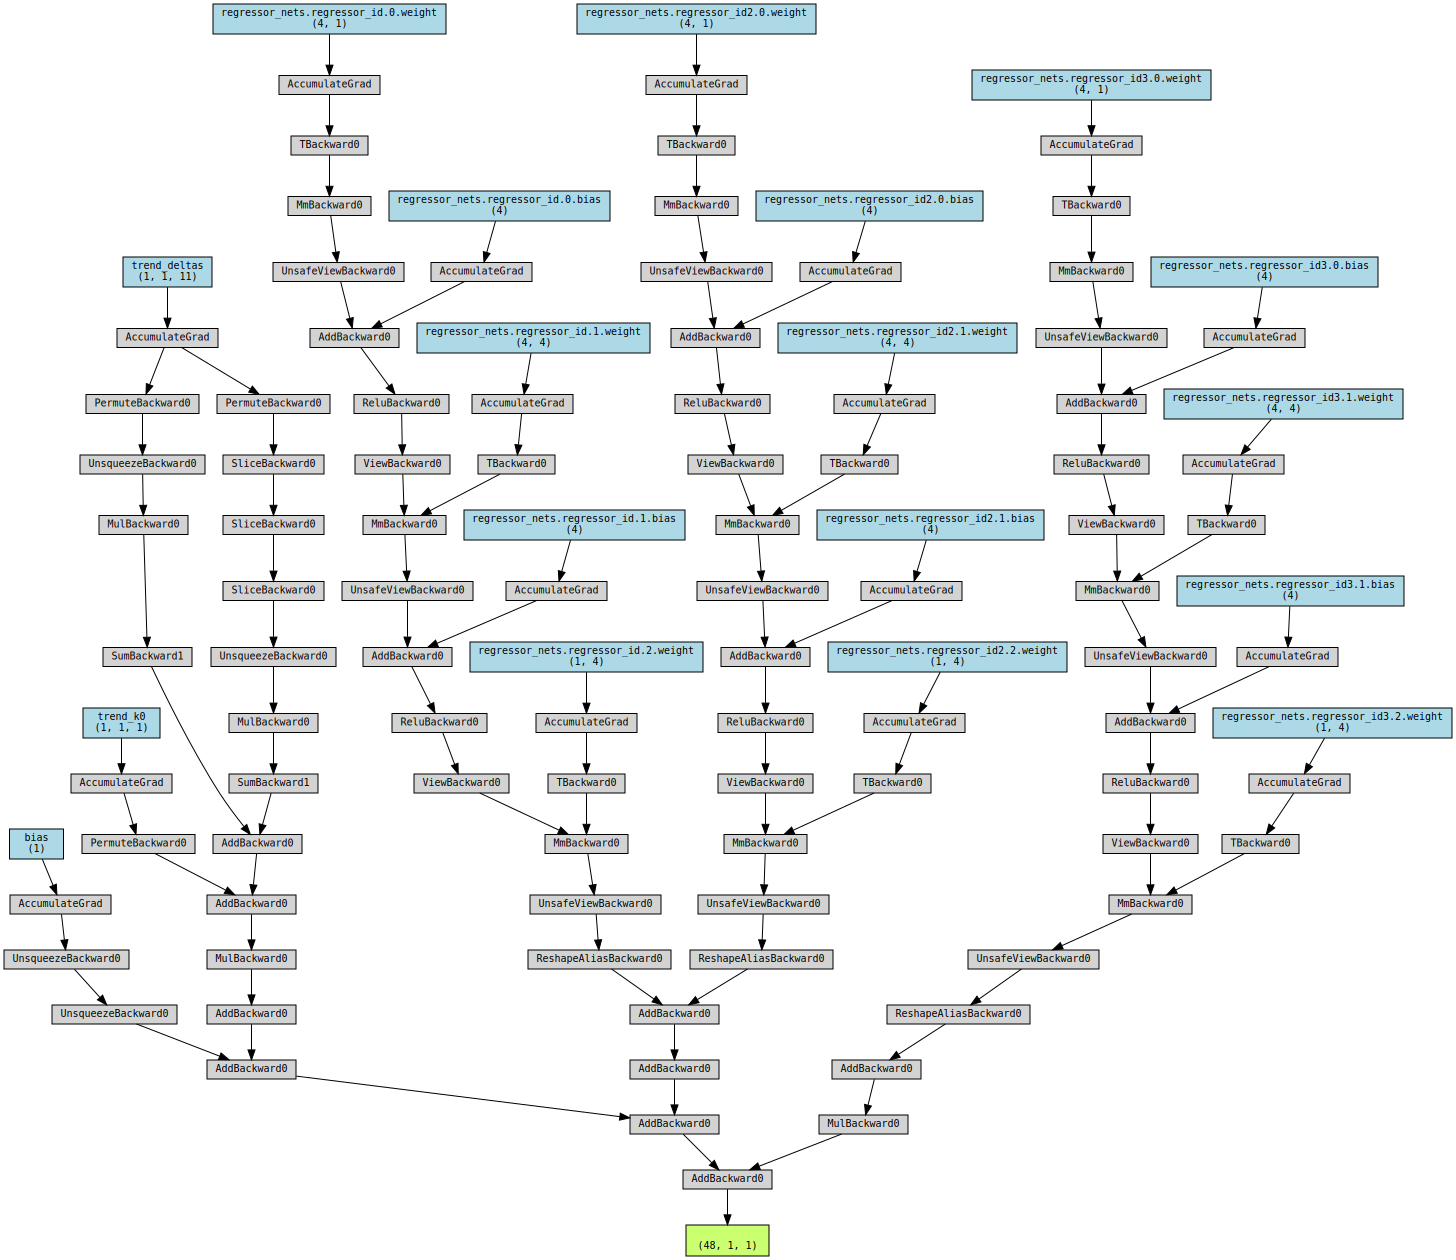

In [31]:
fig = make_dot(m.model.train_epoch_prediction, params=dict(m.model.named_parameters()))
# fig_glob.render(filename='img/fig_glob')
display(fig)

In [32]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True, periods=20, regressors_df=df_global)
forecast = m.predict(future)

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

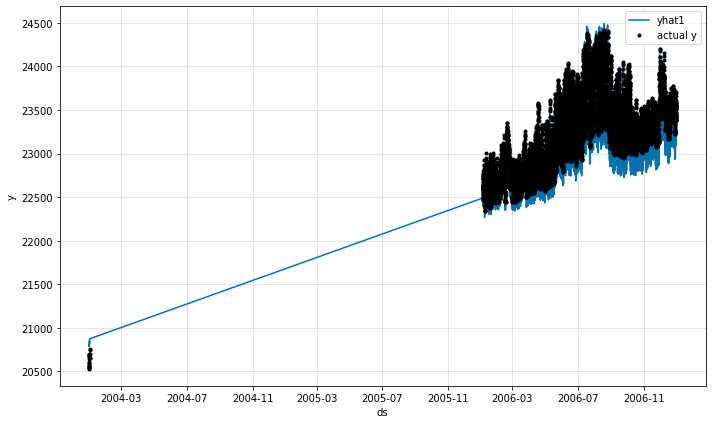

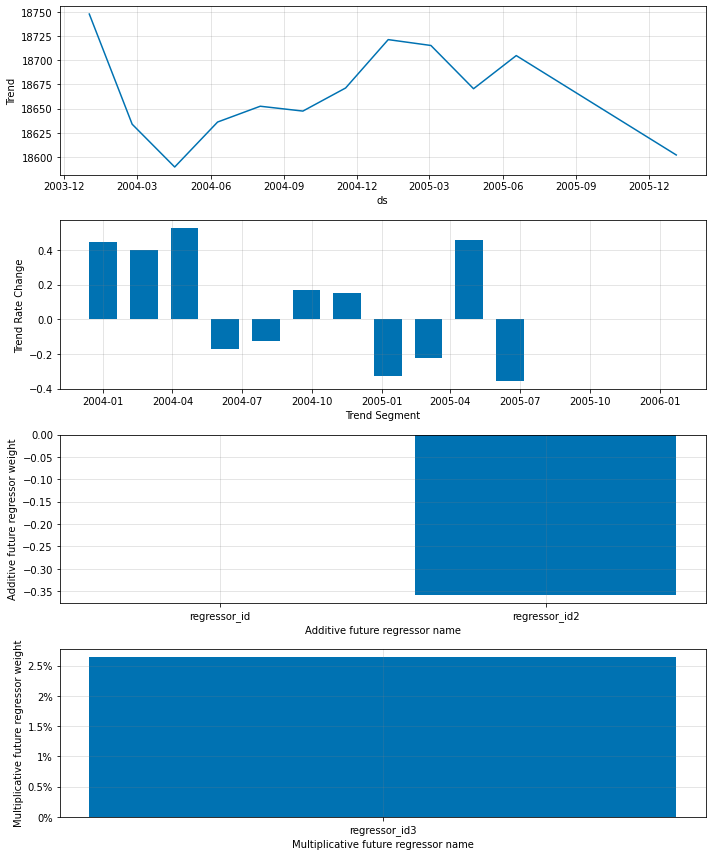

In [33]:
fig = m.plot(forecast[forecast["ID"] == "NORTH"])
fig_param = m.plot_parameters(df_name="NORTH")

In [ ]:
fig = m.plot(forecast[forecast["ID"] == "COAST"])
fig_param = m.plot_parameters(df_name="COAST")

In [ ]:
fig = m.plot(forecast[forecast["ID"] == "EAST"])
fig_param = m.plot_parameters(df_name="EAST")

In [19]:
test_metrics_global = m.test(df_test)
test_metrics_global

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.04340827465057373    │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

,Loss_test,RegLoss_test
0,0.043408,0.0


### GLOCAL TREND 

We will repeat the process above, but for local modelling of trend and seasonality.

In [29]:
m = NeuralProphet(
    trend_global_local="local",
    #     season_global_local="local",
    glocal_trend_reg=3,
    changepoints_range=0.8,
    epochs=2,
    trend_reg=1,
)

1

In [31]:
metrics = m.fit(df_train, freq="H")

Finding best initial lr:   0%|          | 0/278 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [32]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

Predicting: 1102it [00:00, ?it/s]

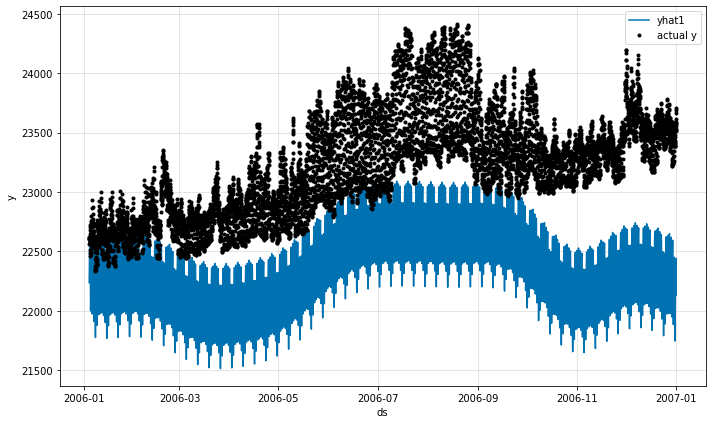

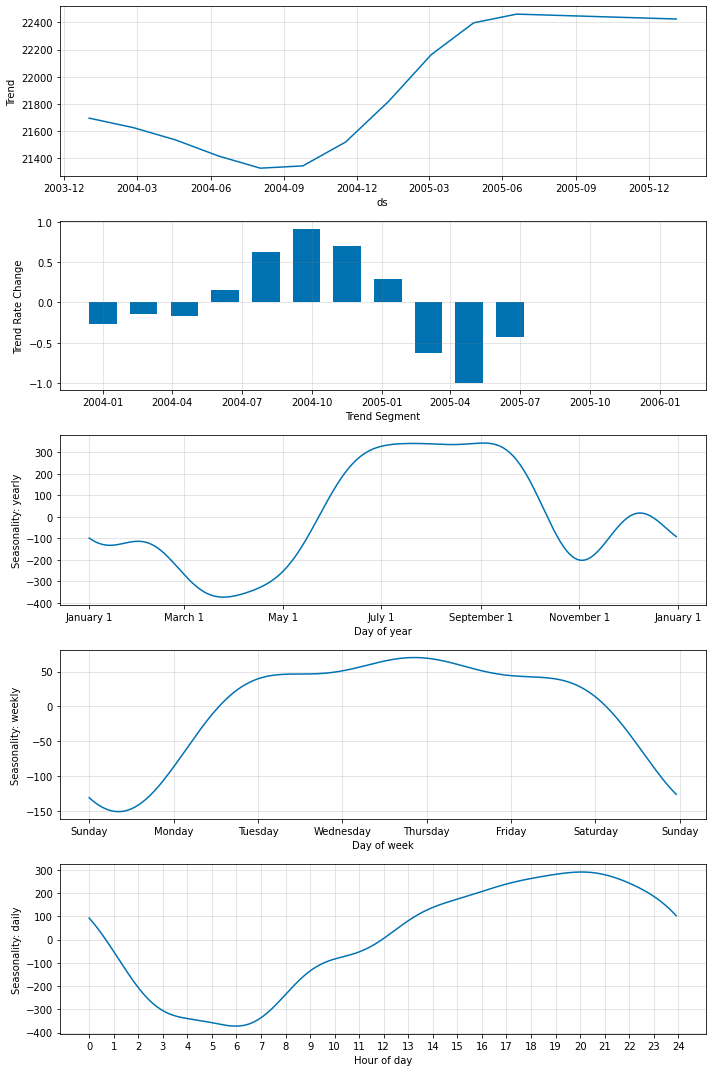

In [33]:
fig = m.plot(forecast[forecast["ID"] == "NORTH"])
fig_param = m.plot_parameters(df_name="NORTH")

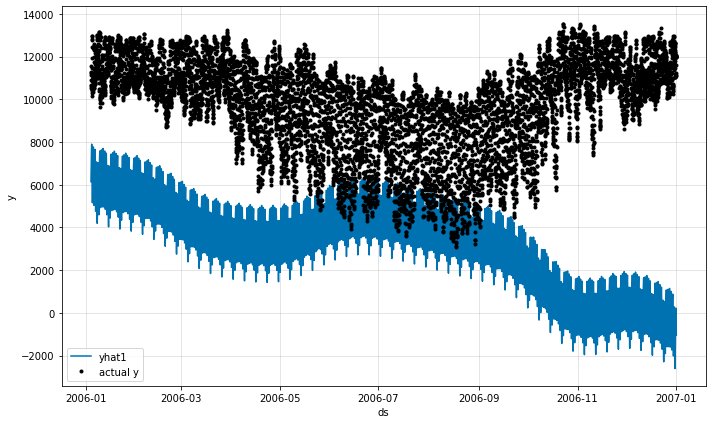

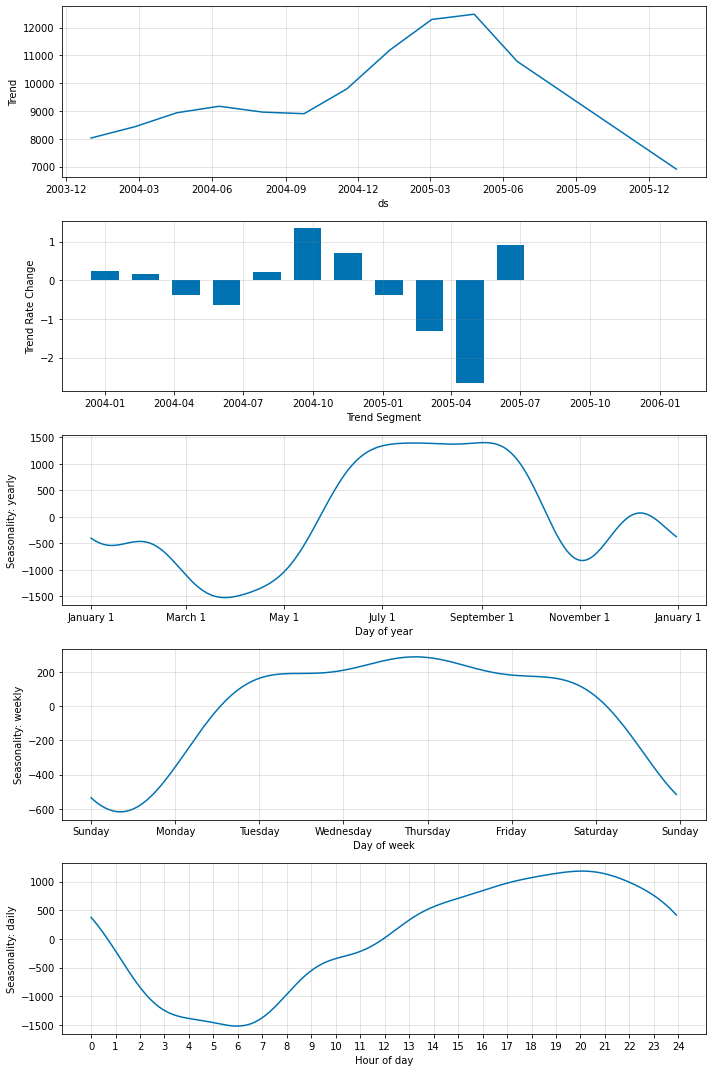

In [34]:
fig = m.plot(forecast[forecast["ID"] == "COAST"])
fig_param = m.plot_parameters(df_name="COAST")

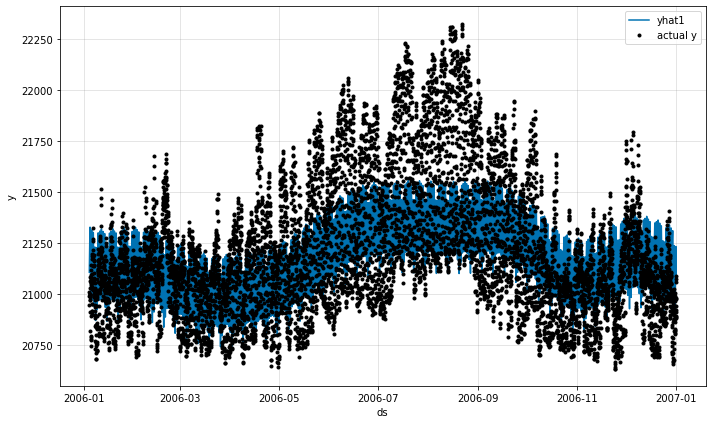

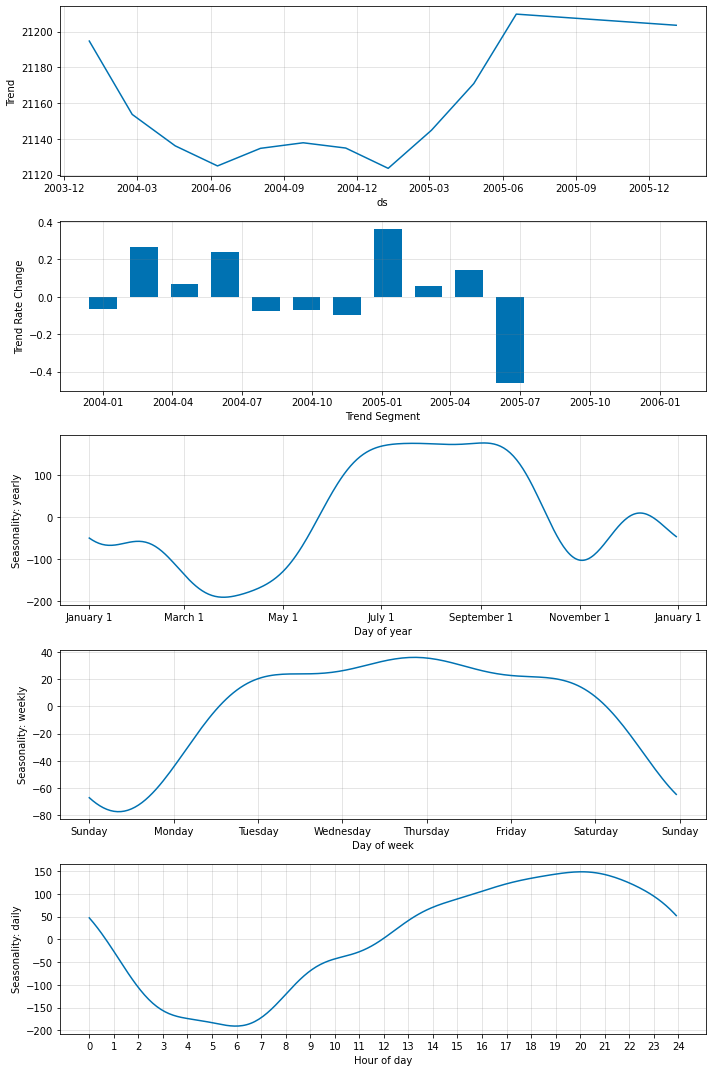

In [35]:
fig = m.plot(forecast[forecast["ID"] == "EAST"])
fig_param = m.plot_parameters(df_name="EAST")

In [26]:
test_metrics_local = m.test(df_test)
test_metrics_local

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.04433564841747284    │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

,Loss_test,RegLoss_test
0,0.044336,0.0


In [27]:
future = m.make_future_dataframe(df_test)
forecast = m.predict(future)
metrics = m.test(df_test)
forecast_trend = m.predict_trend(df_test)
forecast_seasonal_componets = m.predict_seasonal_components(df_test)

ValueError: Invalid frequency: NaT

In [ ]:
fig = make_dot(m.model.train_epoch_prediction, params=dict(m.model.named_parameters()))
# fig_glob.render(filename='img/fig_glob')
display(fig)